# 서울시 공유자전거 '따릉이' 수요 예측 프로젝트
## 단계1. 데이터 전처리

## 0.프로젝트 소개

### (1) 수행 목표
서울시 공유자전거인 '따릉이'의 수요와 날씨간 연관성을 분석을 수행하고자 한다.


#### 풀어야 하는 문제는 무엇인가요?

 - 기상상황이 따릉이 수요에 주는 영향을 분석.
    * 1.데이터를 탐색하며 정보 획득
        * 날씨 데이터와 서울시 공유 자전거 따릉이의 수요 데이터 확인
        * 따릉이의 수요와 날씨간 어떤 연관성이 있는지 탐색
    * 2.EDA
        * 주어진 데이터의 변수들을 분석

### (2) 데이터 소개

#### (1) 기본 데이터
* 학습데이터 : sbikedata.csv

#### (2) 데이터셋의 변수 소개
* date : 날짜
* hour : 시간
* temperature : 온도
* precipitation : 강우 여부, 비가 오지 않았으면 0, 비가 오면 1
* windspeed : 풍속(평균)
* humidity : 습도
* visibility : 시정(視程), 시계(視界)(특정 기상 상태에 따른 가시성을 의미)-10m 단위
* ozone : 오존 수치
* PM10 : 미세먼지 수치(머리카락 굵기의 1/5에서 1/7 크기의 미세먼지)
* PM2.5 : 초미세먼지 수치(머리카락 굵기의 1/20에서 1/30 크기의 미세먼지)
* count : 시간에 따른 따릉이 대여 수


## 1.환경설정

### 라이브러리 호출

In [1]:
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='AppleGothic')
sns.set(font="AppleGothic", 
        rc={"axes.unicode_minus":False}, # 마이너스 부호 깨짐 현상 해결
        style='darkgrid')

from statsmodels.graphics.mosaicplot import mosaic
from scipy import stats as spst
import statsmodels.api as sm
import joblib

# 더 필요한 라이브러리를 아래에 추가합니다.
import warnings
warnings.filterwarnings(action='ignore')
from statsmodels.imputation import mice

### (2) 데이터 불러오기
* 주어진 데이터셋
    * 따릉이 수요 및 날씨 데이터 : sbikedata.csv

#### 1) 데이터로딩

In [2]:
df = pd.read_csv('sbikedata.csv')

In [3]:
df.shape

(5827, 11)

#### 2) 기본 정보 조회
- 데이터를 head, tail. describe, info 등을 활용하여 확인하세요.

In [4]:
df.head(3)

,date,hour,PM10,PM2.5,ozone,temperature,precipitation,windspeed,humidity,visibility,count
0,2021-04-01,1,42.00,21.00,0.00,13.10,0,1.40,49,2000,46
1,2021-04-01,2,41.00,21.00,0.00,12.40,0,2.10,53,2000,40
2,2021-04-01,3,30.00,13.00,0.02,13.10,0,3.40,43,2000,31


In [5]:
df.tail(3)

,date,hour,PM10,PM2.5,ozone,temperature,precipitation,windspeed,humidity,visibility,count
5824,2021-11-29,22,51.00,41.00,0.00,8.60,0,1.90,70,1250,215
5825,2021-11-29,23,43.00,35.00,0.00,8.20,0,2.10,71,1262,125
5826,2021-11-30,0,39.00,31.00,0.00,7.90,0,2.30,71,1483,95


In [6]:
df.describe()

,hour,PM10,PM2.5,ozone,temperature,precipitation,windspeed,humidity,visibility,count
count,5827.00,5725.00,5732.00,5699.00,5827.00,5827.00,5827.00,5827.00,5827.00,5827.00
mean,11.51,31.97,15.67,0.03,19.38,0.08,2.24,68.61,1758.44,215.12
std,6.92,42.99,13.85,0.02,7.50,0.26,1.05,17.28,490.97,185.97
min,0.00,3.00,1.00,0.00,-3.50,0.00,0.00,19.00,60.00,1.00
25%,6.00,16.00,7.00,0.02,14.10,0.00,1.50,56.00,1935.50,53.00
50%,12.00,25.00,13.00,0.03,20.40,0.00,2.20,70.00,2000.00,186.00
75%,18.00,37.00,20.00,0.04,24.90,0.00,2.80,82.00,2000.00,315.00
max,23.00,827.00,125.00,0.14,36.30,1.00,8.30,100.00,2000.00,1746.00


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5827 entries, 0 to 5826
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           5827 non-null   object 
 1   hour           5827 non-null   int64  
 2   PM10           5725 non-null   float64
 3   PM2.5          5732 non-null   float64
 4   ozone          5699 non-null   float64
 5   temperature    5827 non-null   float64
 6   precipitation  5827 non-null   int64  
 7   windspeed      5827 non-null   float64
 8   humidity       5827 non-null   int64  
 9   visibility     5827 non-null   int64  
 10  count          5827 non-null   int64  
dtypes: float64(5), int64(5), object(1)
memory usage: 500.9+ KB


In [8]:
# 'date' 컬럼을 datetime 형태로 변환
df['date'] = pd.to_datetime(df['date'])
# '요일' 컬럼 추가 (월요일=0, 일요일=6)
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['weekday'] = df['date'].dt.weekday

## 2.EDA 1단계 - 데이터 기본 탐색

* 단변량 분석은 데이터분석의 매우 기초적인 분석기법으로, 독립적인 개별 변수가 가지고있는 특성들을 이해하는 과정
    * 개별 변수에 대해 아래 사항들을 분석
        1. 변수가 내포하고 있는 의미
        2. 변수가 수치형인지, 범주형인지
        3. 결측치 존재 여부 및 조치 방안
        4. 기초 통계량 확인
        5. 데이터 분포 확인
        6. 위 정보로부터 파악한 내용 정리
        7. 추가 분석사항 도출

### (1) 변수별 단변량 분석

#### 1) Feature1 : hour

In [9]:
var = 'hour'

변수가 내포하고 있는 의미
- 시간을 24시로 표현

변수가 수치형인지 범주형인지
- 시간은 범주형? 수치형?

In [10]:
df[var].value_counts()
# hour는 24시간제로 표현되어있다.
# 각 시간의 수량은 동일하게 가지고 있다. 따라서 범주형으로 사용할 수 있다.

hour
1     243
14    243
23    243
22    243
21    243
20    243
19    243
18    243
17    243
16    243
15    243
13    243
12    243
11    243
10    243
9     243
8     243
7     243
5     243
0     243
2     242
6     242
3     242
4     241
Name: count, dtype: int64

변수의 결측치 존재 여부 및 조치방안

In [11]:
df[[var]].isna().sum()
# 데이터의 info를 보았을 때, non-null을 보였으며, value_count에서 24시간제의 표현에 어긋나는 표현은 표시되지 않았기때문에
# 결측치는 존재하지 않는다.

hour    0
dtype: int64

변수의 기초 통계량 확인

In [12]:
df[[var]].describe().T

,count,mean,std,min,25%,50%,75%,max
hour,5827.00,11.51,6.92,0.00,6.00,12.00,18.00,23.00


변수의 분포 확인
* kdeplot 활용

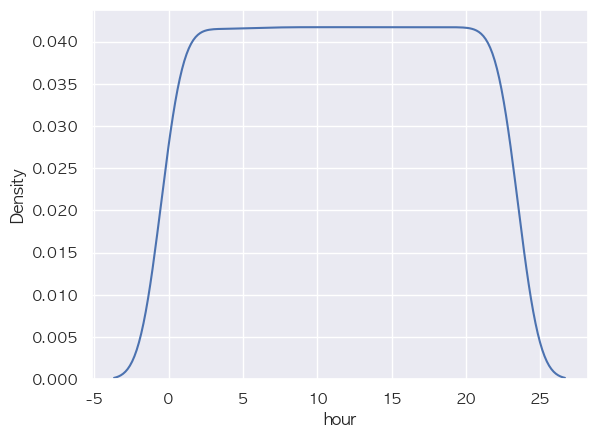

In [13]:
sns.kdeplot(df[var])
plt.show()

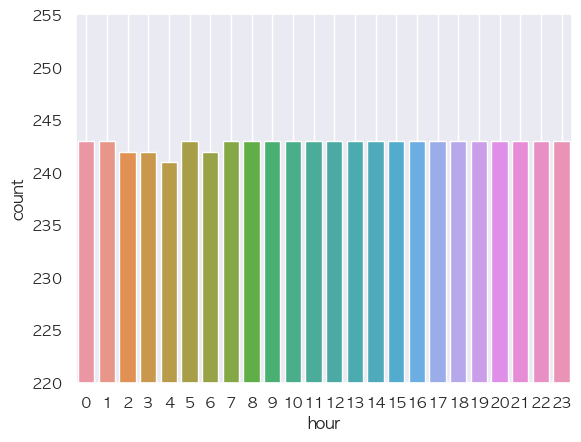

In [16]:
sns.countplot(x='hour', data=df)
plt.ylim(220)
plt.grid()
plt.show()

위 정보로 부터 파악한 내용 정리
- 데이터의 '시간' 열은 5827개 row로 구성되어있으며 결측치는 없음
- 0시 및 일부 중간시간대 데이터가 비어있음

#### 2) Feature2 : temperature

변수가 내포하고 있는 의미
- 따릉이 대여 시점의 온도


In [17]:
var = 'temperature'

변수가 수치형인지 범주형인지
- 기온은 수치형? 범주형?

In [18]:
df[var].value_counts()
# temperature 변수의 경우는 규칙을 통해 분류을 하여 수집한 데이터가 아닌 수치형 값을 그대로 가져왔기 때문에
# 수치형 변수이다.

temperature
21.10    50
24.10    50
22.00    45
20.90    44
18.80    43
         ..
34.10     1
36.10     1
36.00     1
35.60     1
-0.80     1
Name: count, Length: 377, dtype: int64

변수의 결측치 존재 여부 및 조치방안

In [19]:
df[[var]].isna().sum()
# 데이터의 info를 보았을 때, non-null을 보였으며, 데이터의 타입 또한 float형으로 수치형의 규칙을 어긋나지 않았다.
# 결측치는 존재하지 않는다.

temperature    0
dtype: int64

변수의 기초 통계량 확인

In [20]:
df[[var]].describe().T

,count,mean,std,min,25%,50%,75%,max
temperature,5827.00,19.38,7.50,-3.50,14.10,20.40,24.90,36.30


변수의 분포 확인

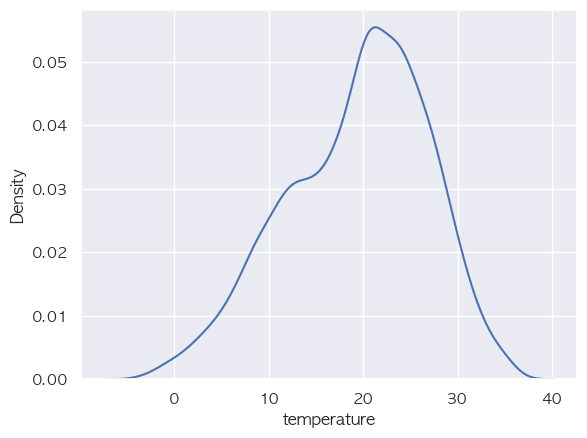

In [21]:
sns.kdeplot(df[var])
plt.show()

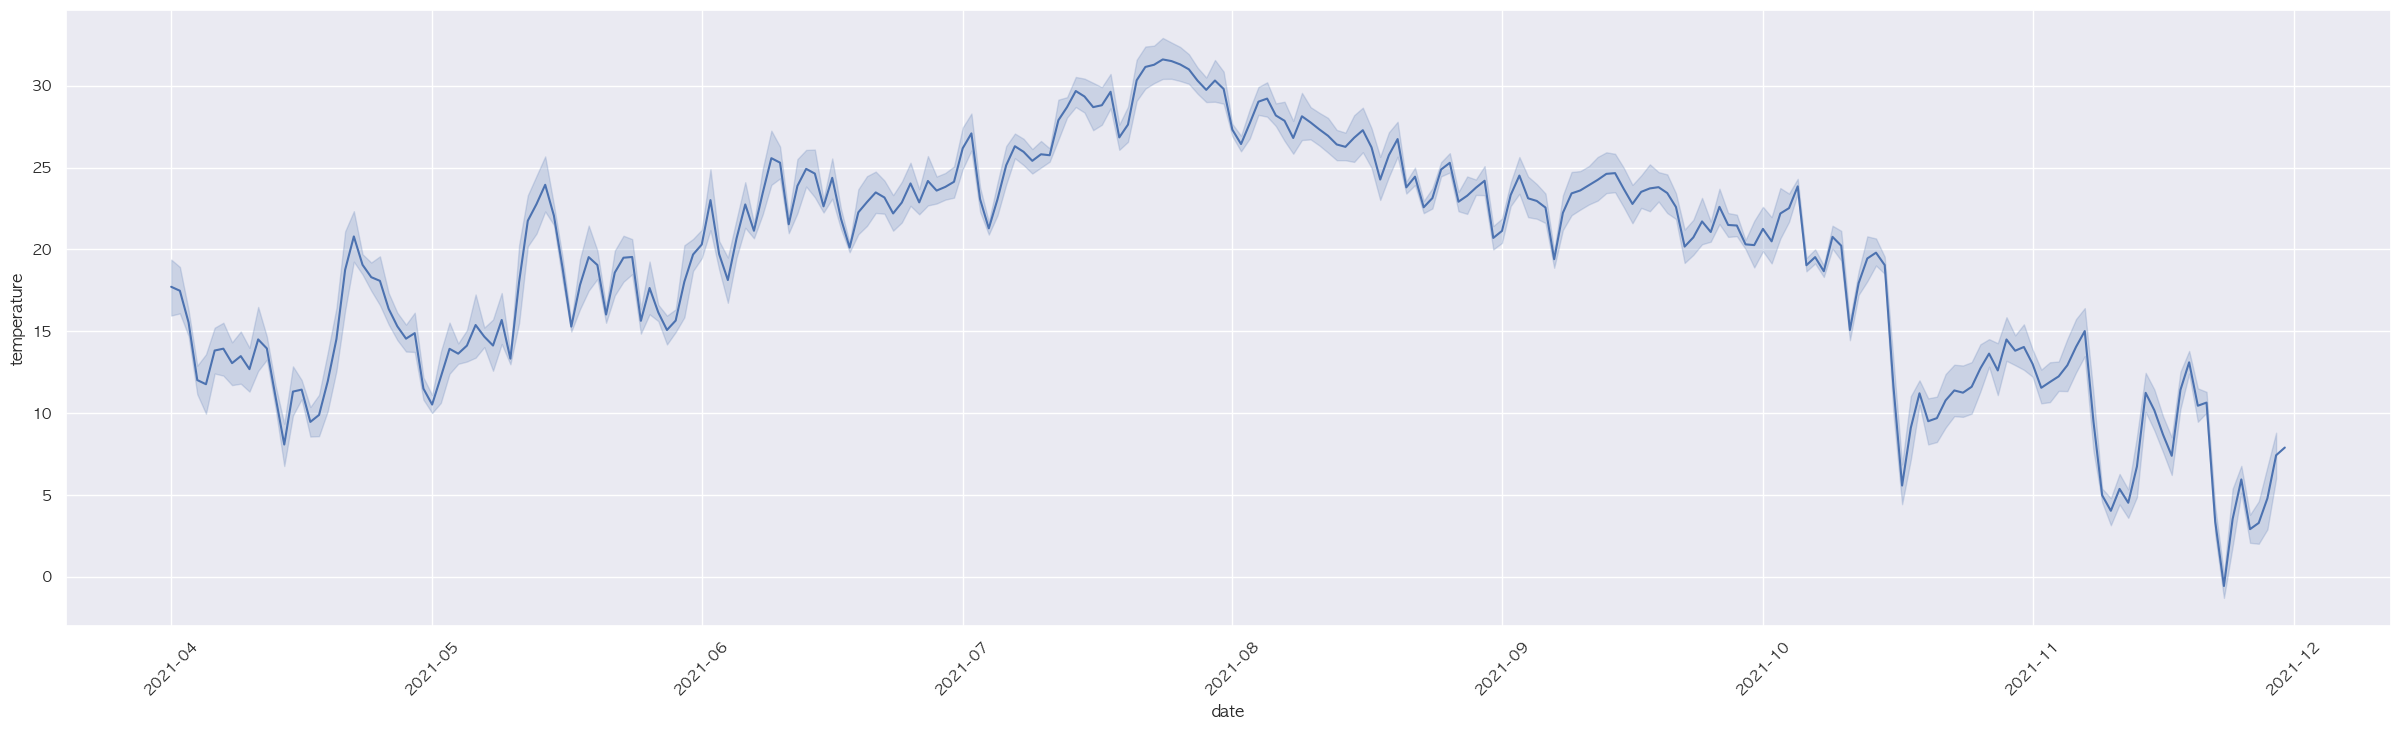

In [22]:
plt.figure(figsize=(30,8))
sns.lineplot(x='date', y=var, data=df)
plt.xticks(rotation=45)
plt.show()

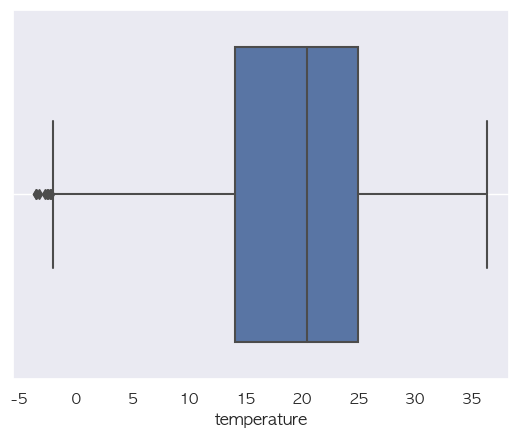

In [23]:
sns.boxplot(x = df[var])
plt.grid()
plt.show()

위 정보로 부터 파악한 내용 정리


#### 3) Feature3 : precipitation

변수가 내포하고 있는 의미
- 따릉이 대여 시점의 강우 여부 (비가 안왔으면 0, 왔으면 1)

In [24]:
var = 'precipitation'

변수가 수치형인지 범주형인지
- 1시간 전 강우 유무는 범주형? 수치형?

In [25]:
df[var].value_counts()
# 0과 1로 이루어진 데이터로 범주형 데이터라고 할 수 있다.

precipitation
0    5387
1     440
Name: count, dtype: int64

변수의 결측치 존재 여부 및 조치 방안


In [26]:
df[[var]].isna().sum()
# 데이터의 정보에서 non-null로 표현 되었으며, 0과1로 이루어진 데이터에서 int형으로 표현되었기 때문에
# 결측치는 없다고 봐야한다

precipitation    0
dtype: int64

변수의 기초 통계량 확인

In [27]:
df[[var]].describe().T

,count,mean,std,min,25%,50%,75%,max
precipitation,5827.00,0.08,0.26,0.00,0.00,0.00,0.00,1.00


변수의 분포 확인

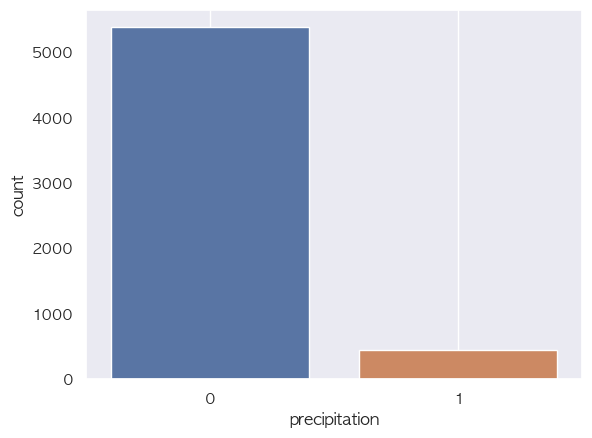

In [28]:
sns.countplot(x=var, data=df)
plt.grid()
plt.show()

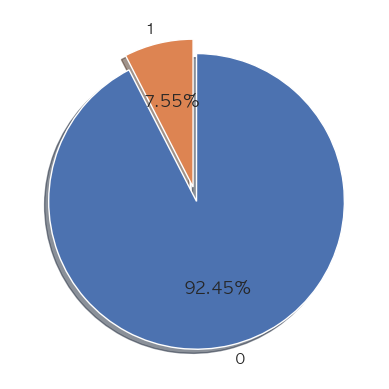

In [29]:
temp = df[var].value_counts()
plt.pie(temp.values, labels = temp.index, autopct = '%.2f%%',
        startangle=90, counterclock=False,
        explode = [0.05, 0.05], shadow=True)
plt.show()

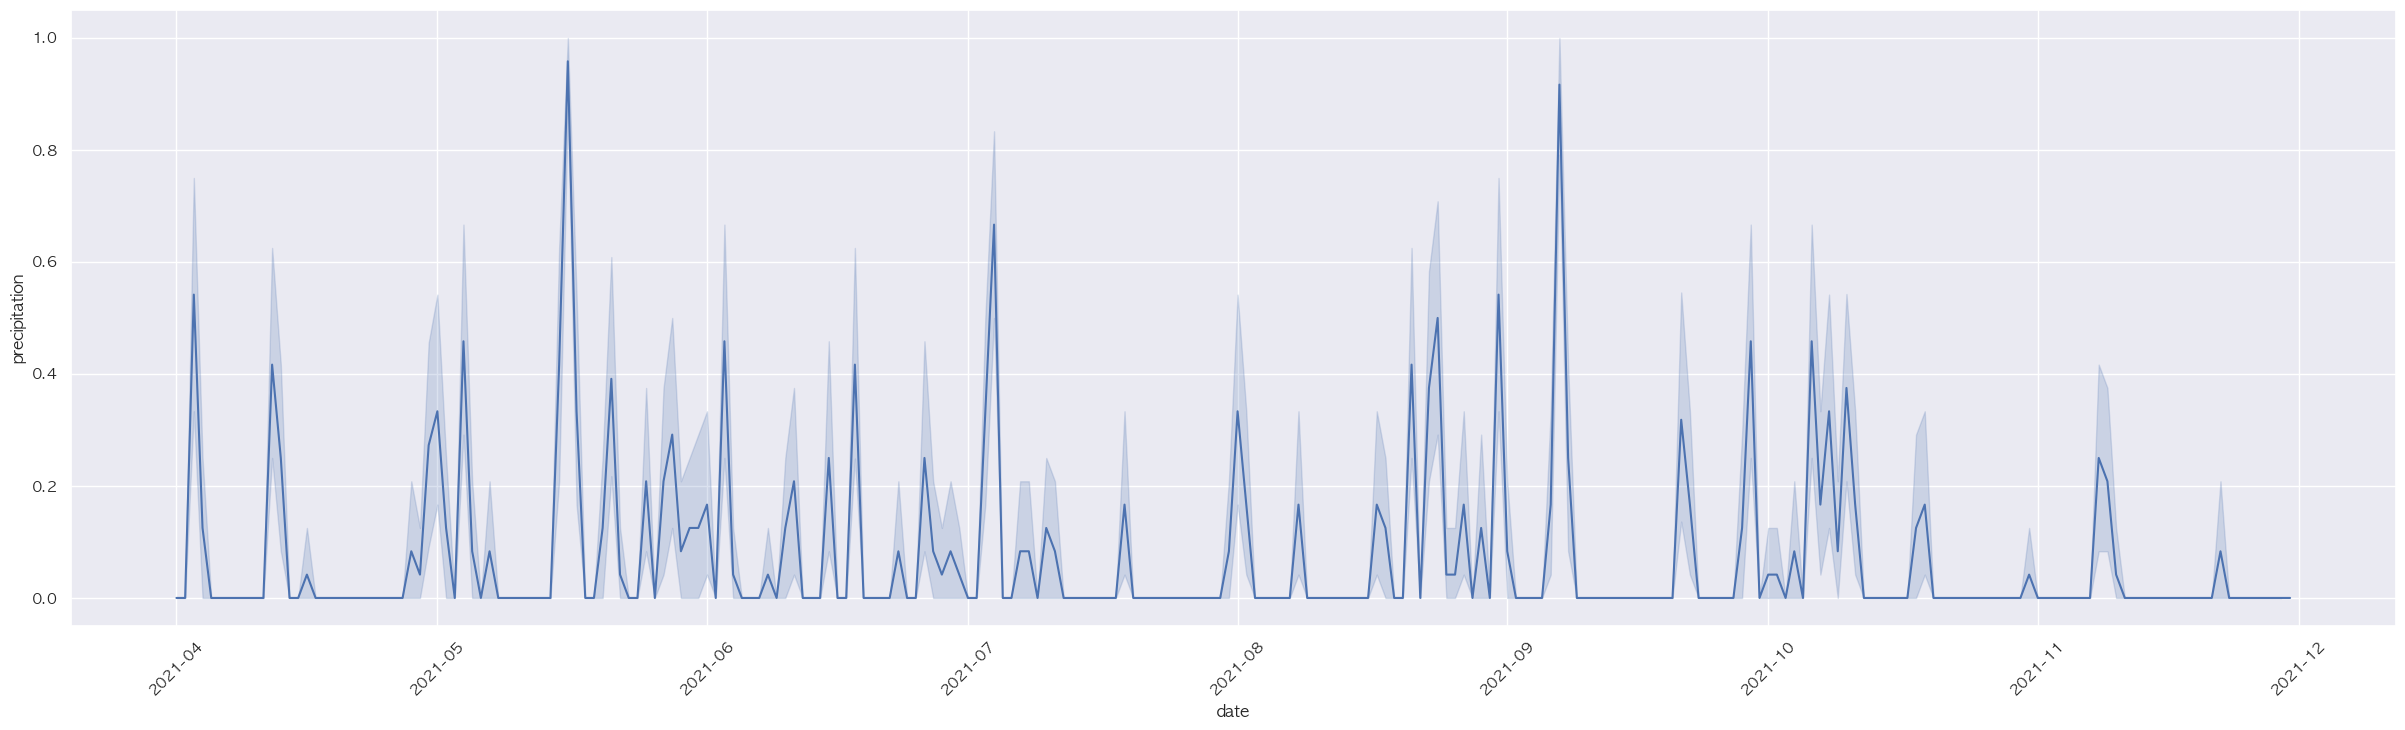

In [95]:
plt.figure(figsize=(30,8))
sns.lineplot(x='date', y='precipitation', data=df)
plt.xticks(rotation=45)
plt.show()

위 정보로 부터 파악한 내용 정리


#### 4) Feature4 : windspeed

변수가 내포하고 있는 의미
- 따릉이 대여 시점의 풍속, 풍량

In [30]:
var = 'windspeed'

변수가 수치형인지 범주형인지


In [31]:
df[var].value_counts()
# 변수 안에 다양한 숫자형 데이터가 존재하고 있으므로 수치형 변수이다.

windspeed
2.30    255
2.20    246
2.10    242
1.90    239
1.70    235
       ... 
6.90      1
5.80      1
6.80      1
6.40      1
6.20      1
Name: count, Length: 72, dtype: int64

변수의 결측치 존재 여부 및 조치방안

In [32]:
df[[var]].isna().sum()
# 데이터의 정보에서 non-null로 nan인 데이터가 없고, 변수의 포함된 데이터도 정수형으로 정보를 확인할 수 있기 때문에
# 결측치는 없다

windspeed    0
dtype: int64

변수의 기초 통계량 확인

In [33]:
df[[var]].describe().T

,count,mean,std,min,25%,50%,75%,max
windspeed,5827.00,2.24,1.05,0.00,1.50,2.20,2.80,8.30


변수의 분포 확인

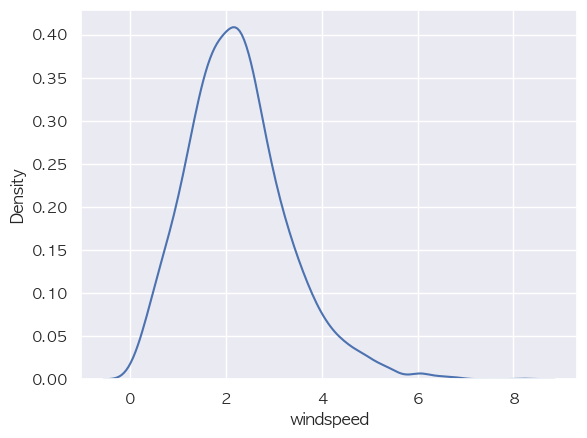

In [34]:
sns.kdeplot(df[var])
plt.show()

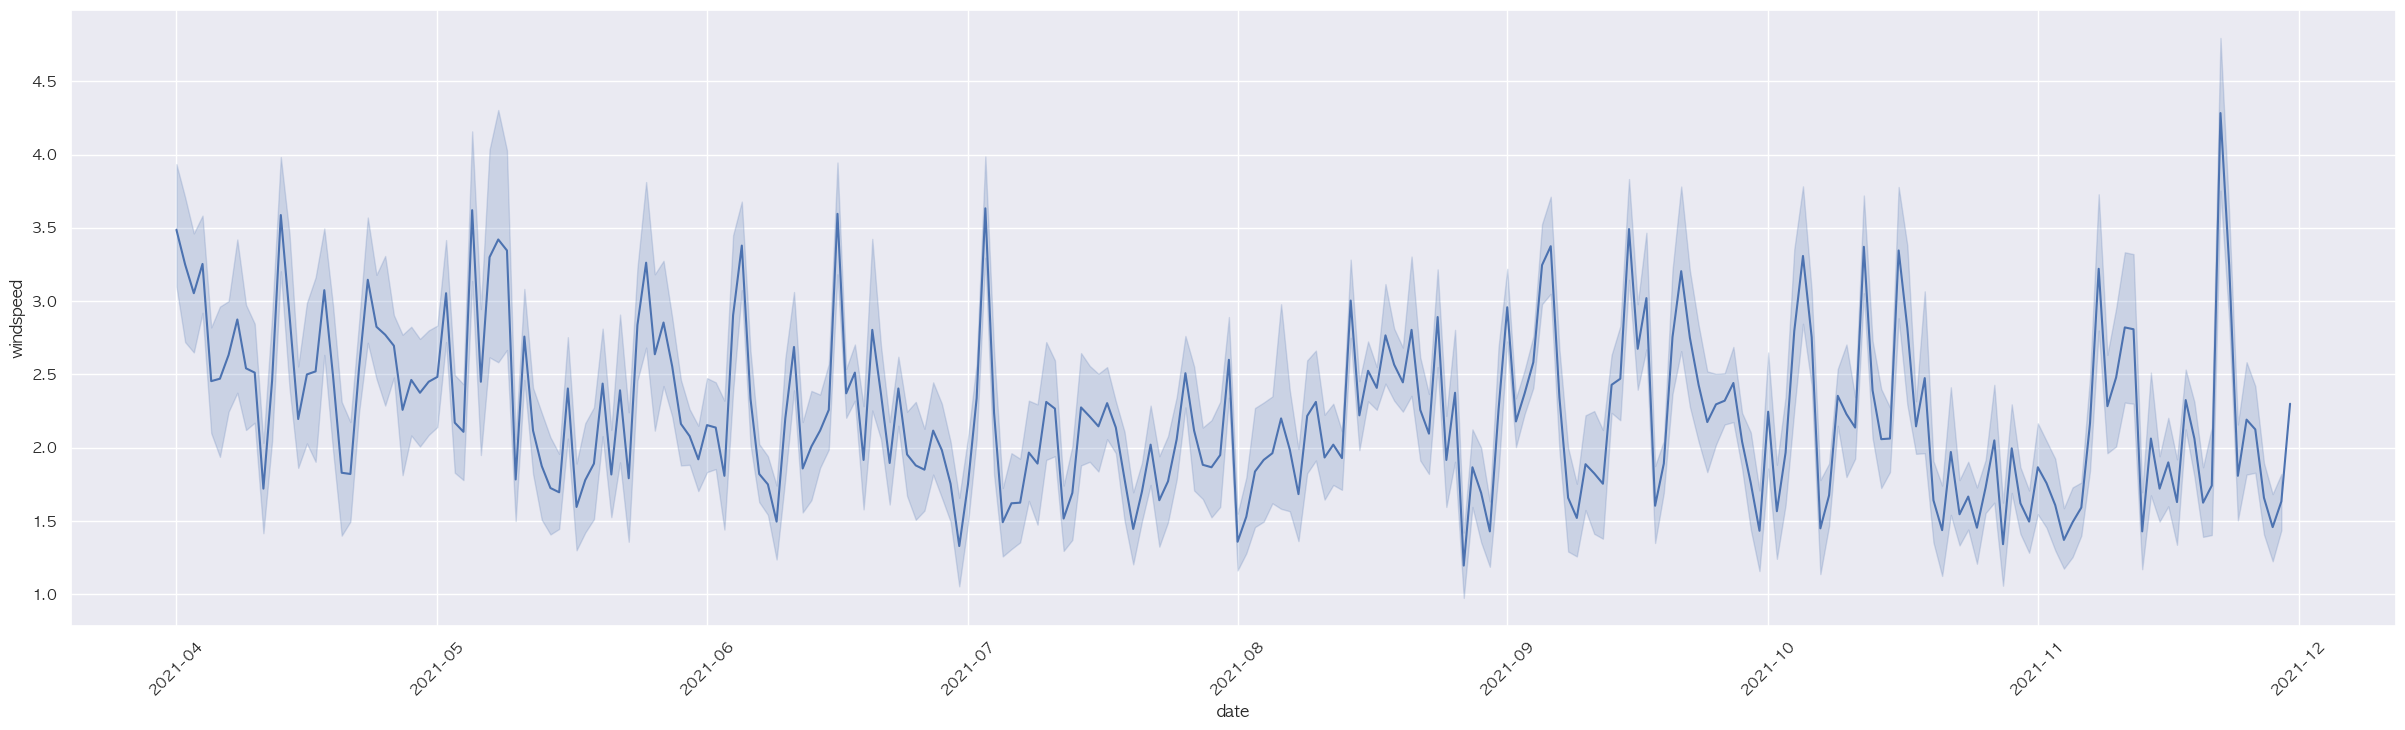

In [35]:
plt.figure(figsize=(30,8))
sns.lineplot(x='date', y=var, data=df)
plt.xticks(rotation=45)
plt.show()

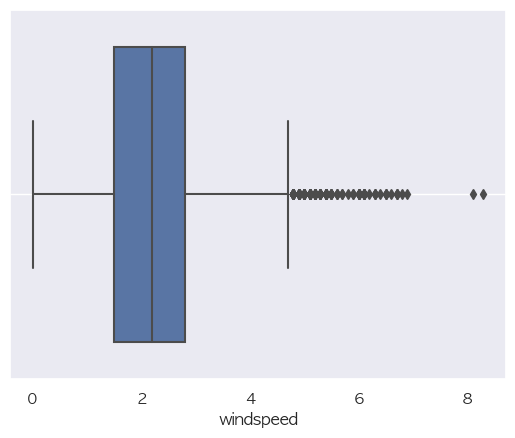

In [36]:
sns.boxplot(x = df[var])
plt.grid()
plt.show()

위 정보로 부터 파악한 내용 정리


#### 5) Feature5 : humidity

변수가 내포하고 있는 의미
- 따릉이 대여 시점의 습도

In [37]:
var = 'humidity'

변수가 수치형인지 범주형인지


In [38]:
df[var].value_counts()
# 숫자형 데이터로 분포를 넓게 가지고 있기 때문에 수치형 변수이다.

humidity
70    142
76    138
75    128
63    127
77    127
     ... 
24      4
20      3
21      2
22      2
19      1
Name: count, Length: 82, dtype: int64

변수의 결측치 존재 여부 및 조치방안

In [39]:
df[[var]].isna().sum()
# 데이터에서 non-null로 nandl 없을을 확인하였고 정수형 변수만 포함하고 있기 때문에
# 결측치는 없다.

humidity    0
dtype: int64

변수의 기초 통계량 확인

In [40]:
df[[var]].describe().T

,count,mean,std,min,25%,50%,75%,max
humidity,5827.00,68.61,17.28,19.00,56.00,70.00,82.00,100.00


변수의 분포 확인

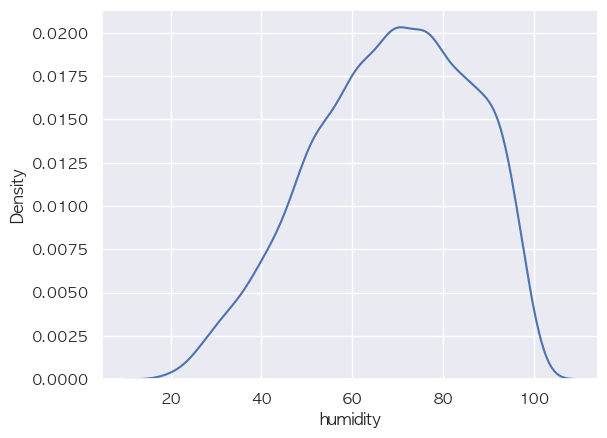

In [41]:
sns.kdeplot(df[var])
plt.show()

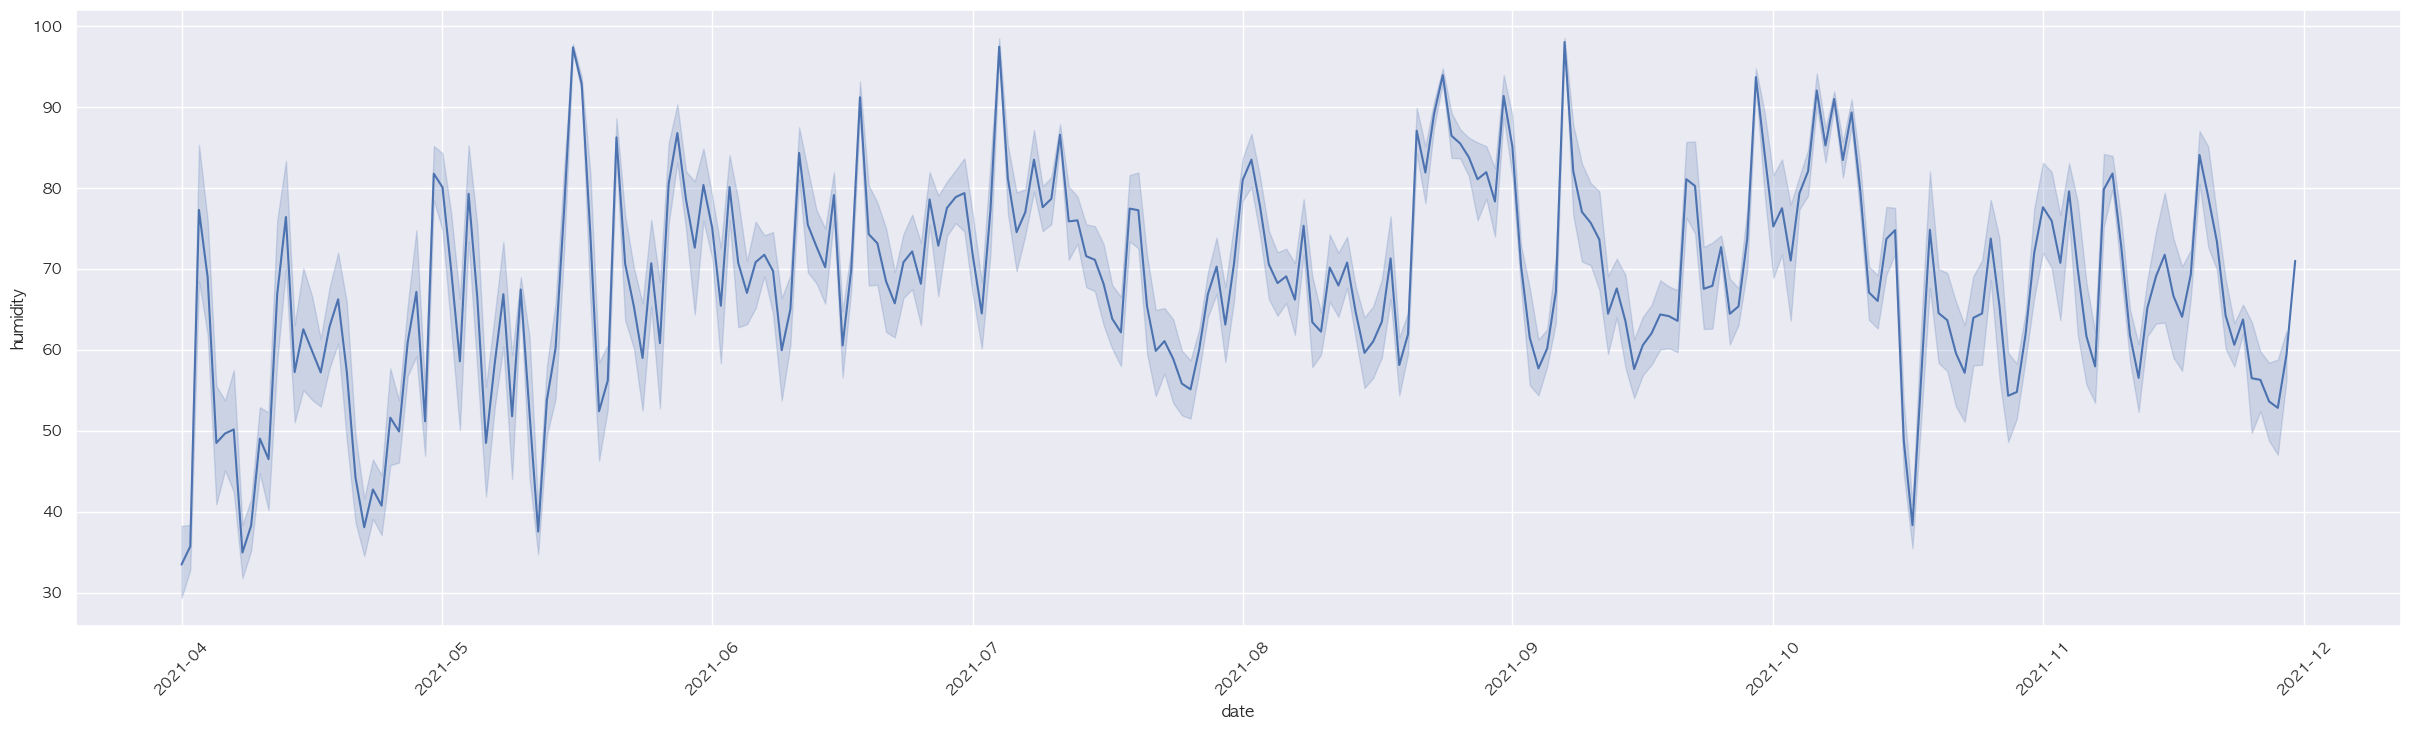

In [42]:
plt.figure(figsize=(30,8))
sns.lineplot(x='date', y=var, data=df)
plt.xticks(rotation=45)
plt.show()

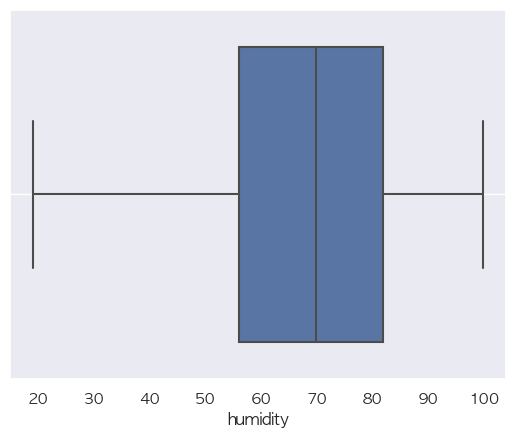

In [43]:
sns.boxplot(x = df[var])
plt.grid()
plt.show()

위 정보로 부터 파악한 내용 정리


#### 6) Feature6 : visibility

변수가 내포하고 있는 의미
- 대여 시점의 시계 (시정 거리)

In [44]:
var = 'visibility'

변수가 수치형인지 범주형인지

In [45]:
df[var].value_counts()
# 숫자 데이터로 넓은 분포를 가지고 있기 때문에 수치형 변수이다.

visibility
2000    4218
1996       8
1984       7
1992       7
1997       6
        ... 
1756       1
313        1
848        1
1406       1
1250       1
Name: count, Length: 1032, dtype: int64

변수의 결측치 존재 여부 및 조치방안

In [46]:
df[[var]].isna().sum()
# 데이터의 정보에서 non-null로 nan이 없고 정수형의 데이터만 포함하고 있기 때문에
# 결측치는 없다

visibility    0
dtype: int64

변수의 기초 통계량 확인

In [47]:
df[[var]].describe().T

,count,mean,std,min,25%,50%,75%,max
visibility,5827.00,1758.44,490.97,60.00,1935.50,2000.00,2000.00,2000.00


변수의 분포 확인

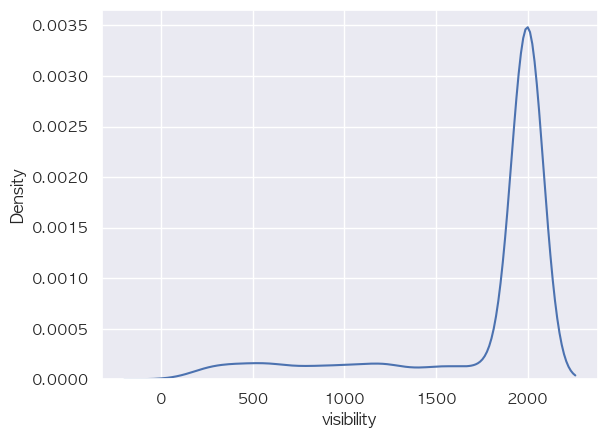

In [48]:
sns.kdeplot(df[var])
plt.show()

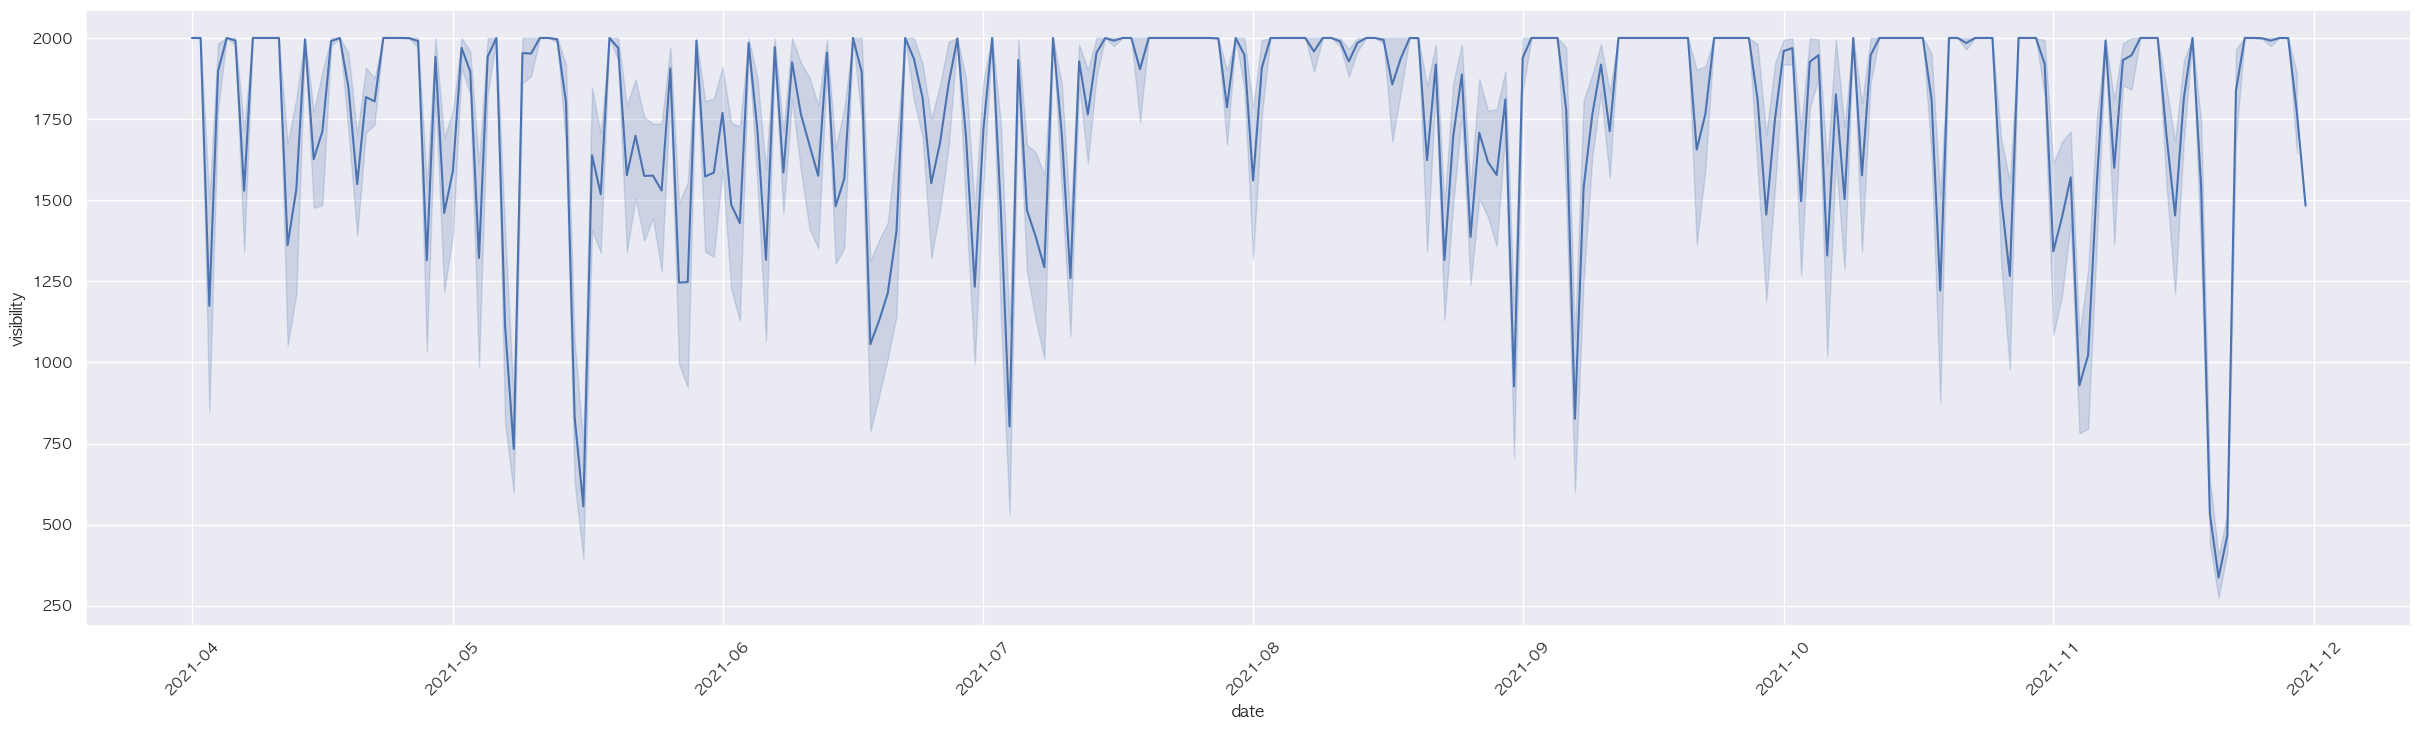

In [49]:
plt.figure(figsize=(30,8))
sns.lineplot(x='date', y=var, data=df)
plt.xticks(rotation=45)
plt.show()

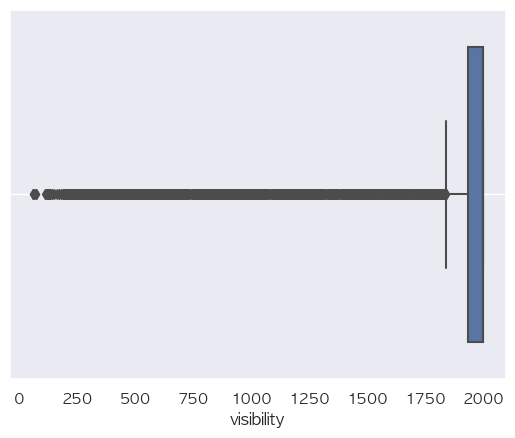

In [50]:
sns.boxplot(x = df[var])
plt.grid()
plt.show()

위 정보로 부터 파악한 내용 정리


#### 7) Feature7 : ozone

변수가 내포하고 있는 의미
- 따릉이 대여 시점의 오존 수치

In [51]:
var = 'ozone'

변수가 수치형인지 범주형인지


In [52]:
df[var].value_counts()
# 정수 데이터가 

ozone
0.00    177
0.03    170
0.03    162
0.03    161
0.03    160
       ... 
0.12      1
0.10      1
0.12      1
0.11      1
0.11      1
Name: count, Length: 109, dtype: int64

변수의 결측치 존재 여부 및 조치방안

In [53]:
df[[var]].isna().sum()
# 데이터의 정보에서 nan의 값은 없지만, 값이 존재하지 않는 결측치는 존재한다.

ozone    128
dtype: int64

만약 결측치가 존재한다면?-> 어떻게 처리할 것인가?

In [59]:
# 변수의 결측값을 앞뒤 관측값으로 선형 보간
df[var] = df[var].interpolate(method='linear')
print(df[[var]].isna().sum())

ozone    0
dtype: int64


In [ ]:
# # MICE(Multiple Imputation by Chained Equations) 방법을 사용하여 결측치를 처리한다
# df2 = df.copy()
# df2.drop('date',axis=1,inplace=True)
# df2 = df2.rename(columns={"PM2.5": "PM2_5"})
# # MICE 모델 초기화
# imp = mice.MICEData(df2)
# # MICE를 이용한 결측치 대체 수행 (기본적으로 10번의 반복으로 설정되어 있음)
# imp.update_all(10)
# # 대체된 데이터셋 추출
# filled_data = imp.data

# df['ozone'] = filled_data['ozone']
# print(df[[var]].isna().sum())

변수의 기초 통계량 확인

In [55]:
df[[var]].describe().T

,count,mean,std,min,25%,50%,75%,max
ozone,5827.00,0.03,0.02,0.00,0.02,0.03,0.04,0.14


변수의 분포 확인

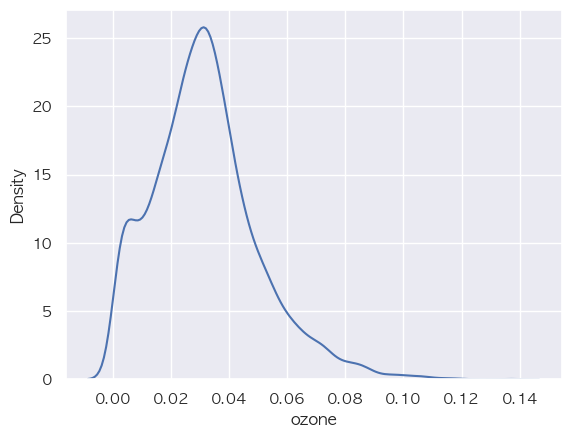

In [56]:
sns.kdeplot(df[var])
plt.show()

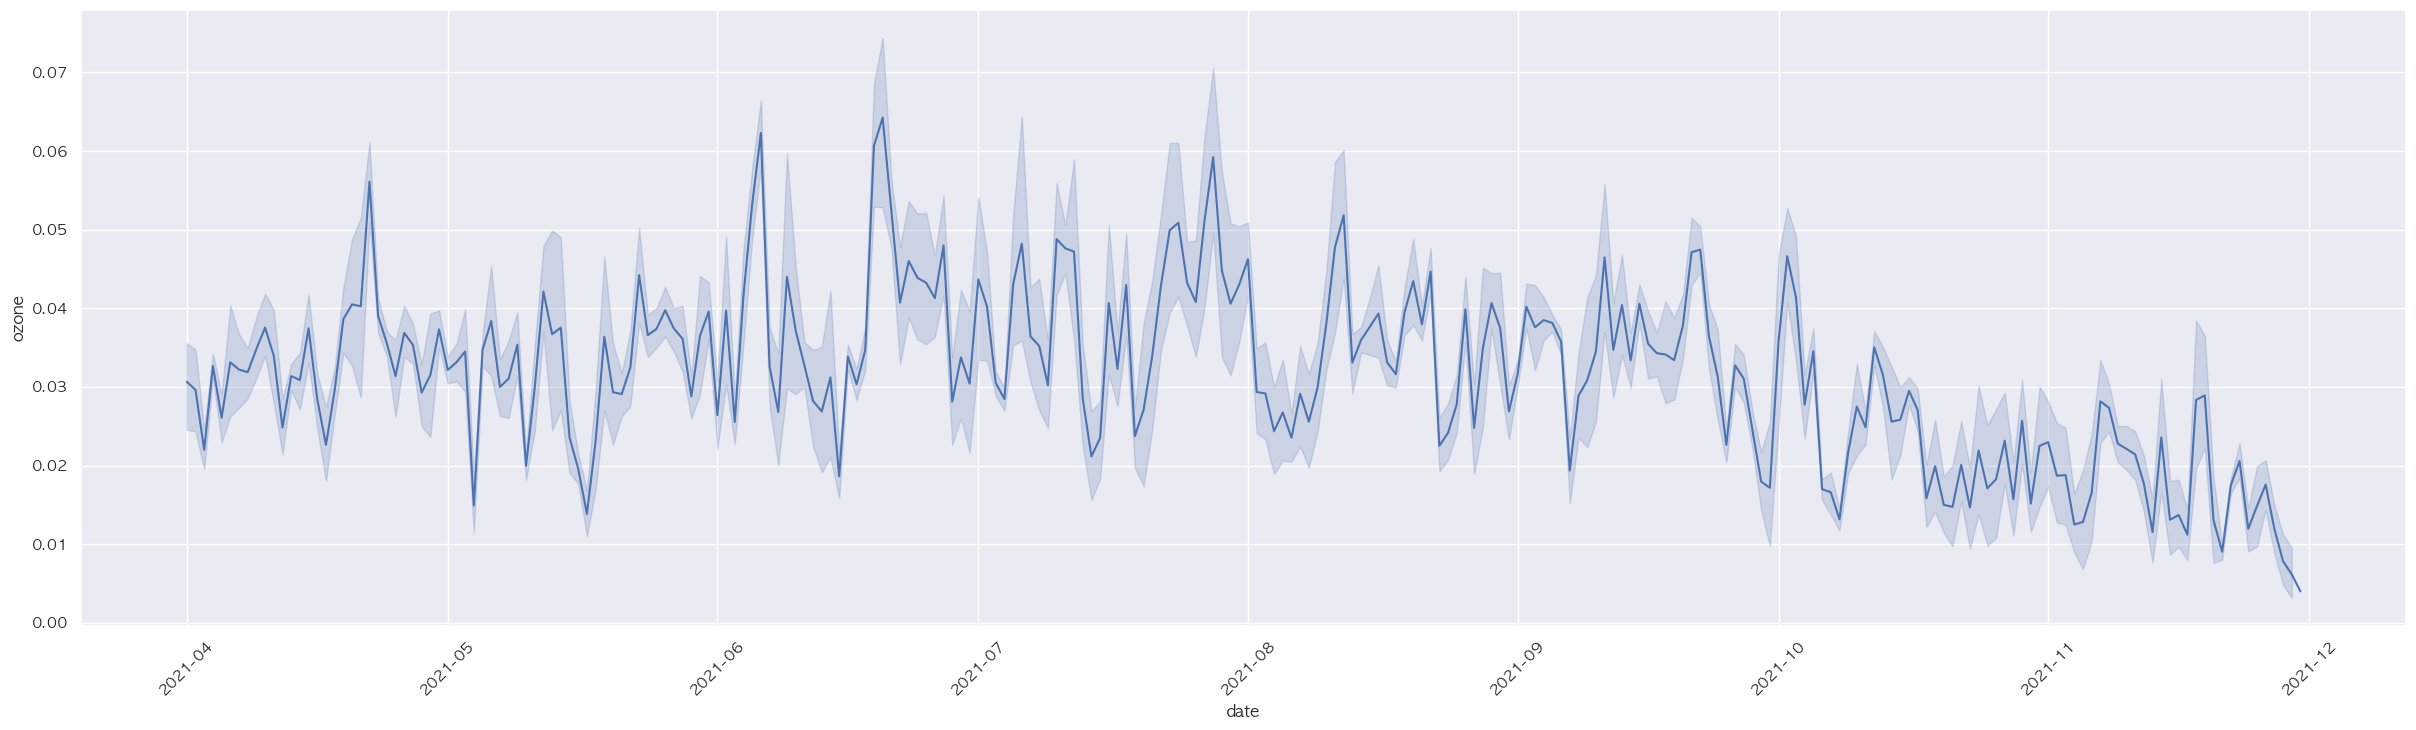

In [57]:
plt.figure(figsize=(30,8))
sns.lineplot(x='date', y=var, data=df)
plt.xticks(rotation=45)
plt.show()

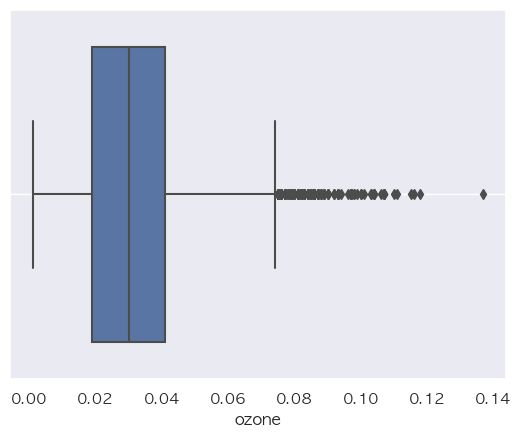

In [58]:
sns.boxplot(x = df[var])
plt.grid()
plt.show()

위 정보로 부터 파악한 내용 정리


#### 8) Feature8 : PM10

변수가 내포하고 있는 의미
- 따릉이 대여 시점의 미세먼지 농도

In [60]:
var = 'PM10'

변수가 수치형인지 범주형인지


In [61]:
df[var].value_counts()

PM10
18.00     181
22.00     179
20.00     177
16.00     174
23.00     173
         ... 
296.00      1
373.00      1
433.00      1
479.00      1
332.00      1
Name: count, Length: 189, dtype: int64

변수의 결측치 존재 여부 및 조치방안

In [62]:
df[[var]].isna().sum()

PM10    102
dtype: int64

In [63]:
# 변수의 결측값을 앞뒤 관측값으로 선형 보간
df[var] = df[var].interpolate(method='linear')
print(df[[var]].isna().sum())

PM10    0
dtype: int64


변수의 기초 통계량 확인

In [64]:
df[[var]].describe().T

,count,mean,std,min,25%,50%,75%,max
PM10,5827.00,31.83,42.65,3.00,16.00,25.00,37.00,827.00


변수의 분포 확인

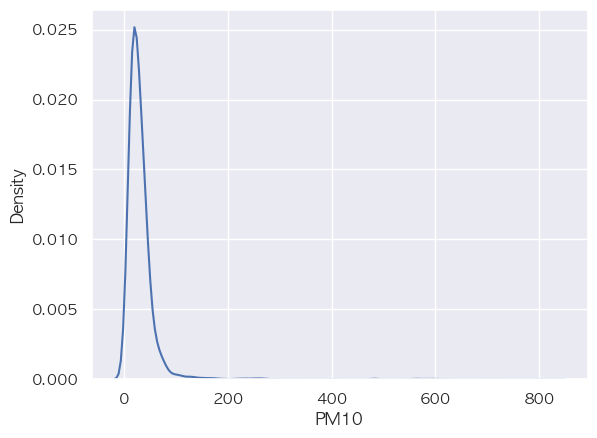

In [65]:
sns.kdeplot(df[var])
plt.show()

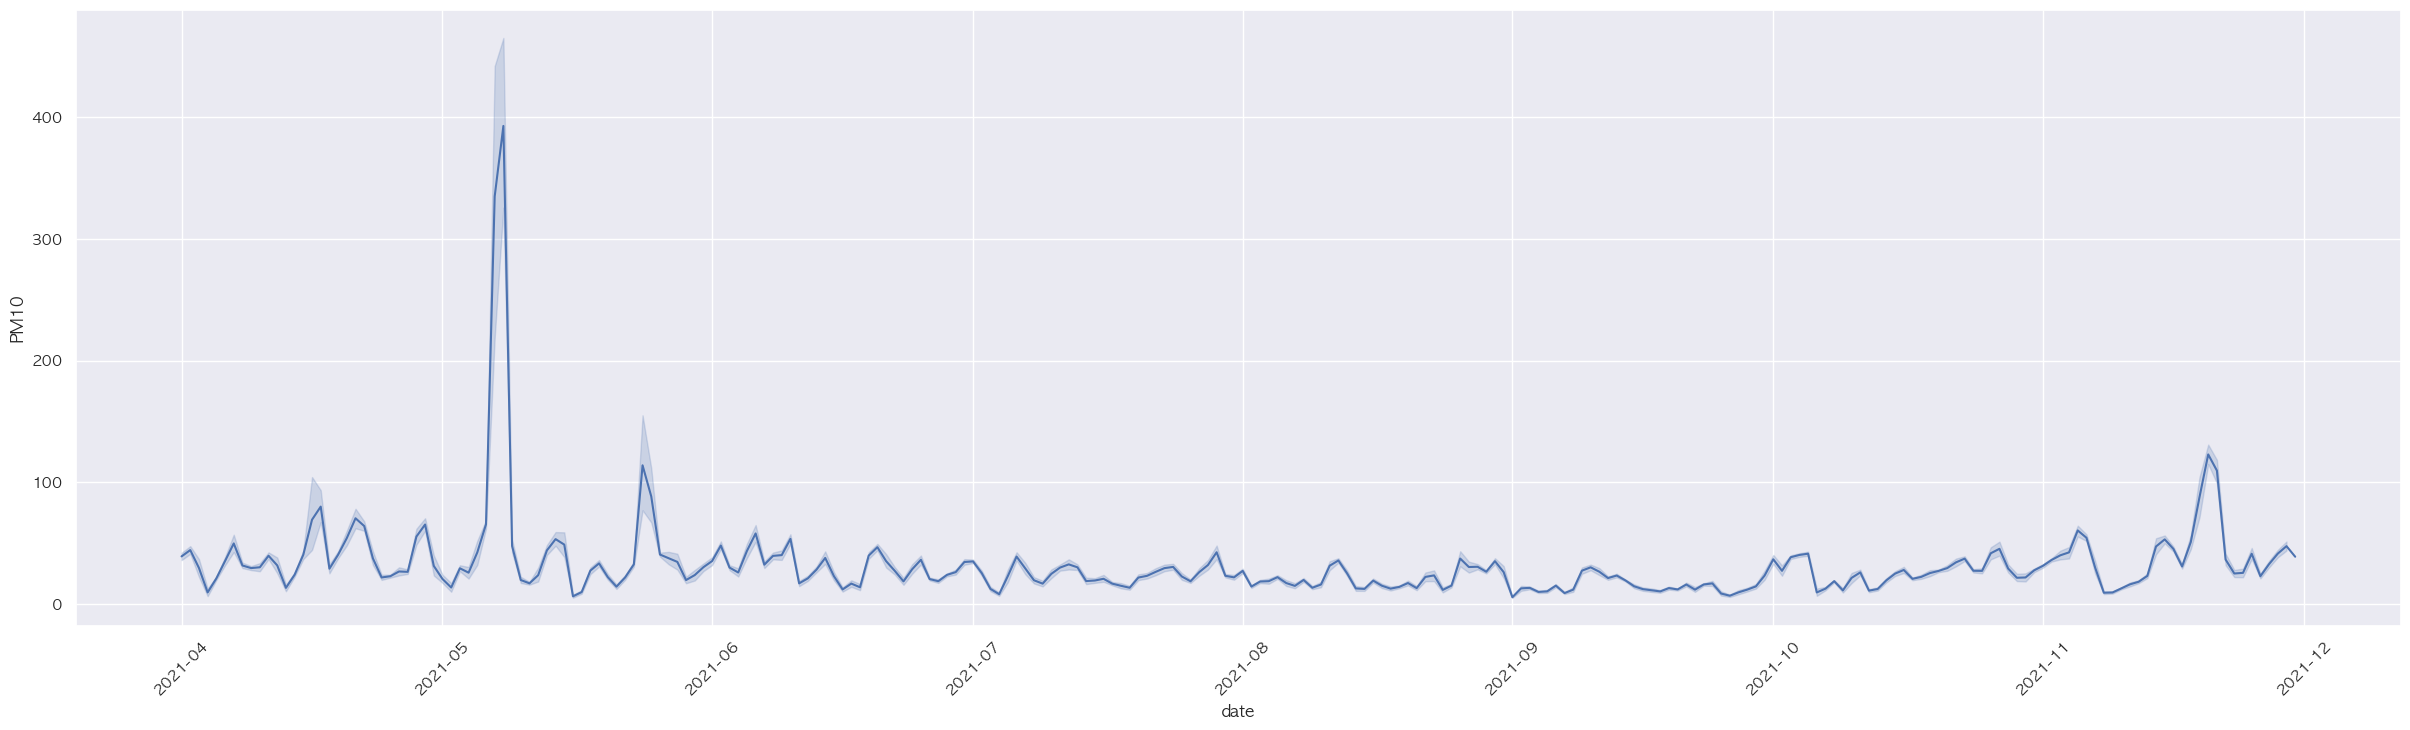

In [66]:
plt.figure(figsize=(30,8))
sns.lineplot(x='date', y=var, data=df)
plt.xticks(rotation=45)
plt.show()

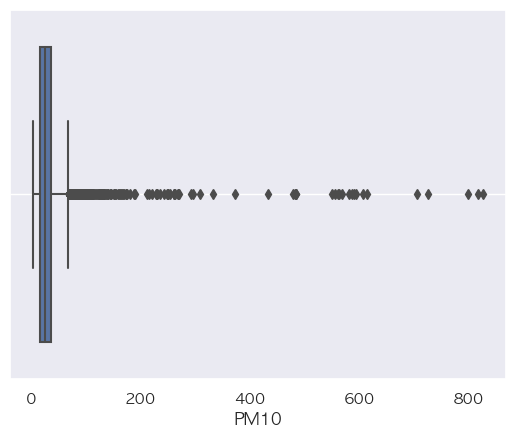

In [67]:
sns.boxplot(x = df[var])
plt.grid()
plt.show()

위 정보로 부터 파악한 내용 정리


#### 9) Feature9 : PM2.5

변수가 내포하고 있는 의미
- 따릉이 대여시점의 초미세먼지 수치

In [68]:
var = 'PM2.5'

변수가 수치형인지 범주형인지


In [69]:
df[var].value_counts()

PM2.5
5.00      265
7.00      262
11.00     259
12.00     256
13.00     255
         ... 
115.00      1
117.00      1
106.00      1
86.00       1
82.00       1
Name: count, Length: 110, dtype: int64

변수의 결측치 존재 여부 및 조치방안

In [70]:
df[[var]].isna().sum()

PM2.5    95
dtype: int64

In [71]:
# 변수의 결측값을 앞뒤 관측값으로 선형 보간
df[var] = df[var].interpolate(method='linear')
print(df[[var]].isna().sum())

PM2.5    0
dtype: int64


변수의 기초 통계량 확인

In [72]:
df[[var]].describe().T

,count,mean,std,min,25%,50%,75%,max
PM2.5,5827.00,15.63,13.79,1.00,7.00,13.00,20.00,125.00


변수의 분포 확인

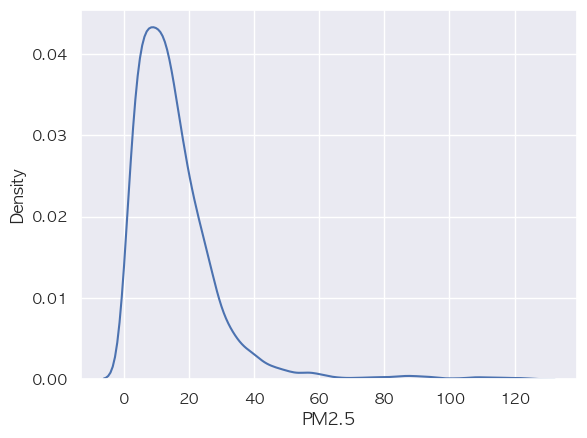

In [73]:
sns.kdeplot(df[var])
plt.show()

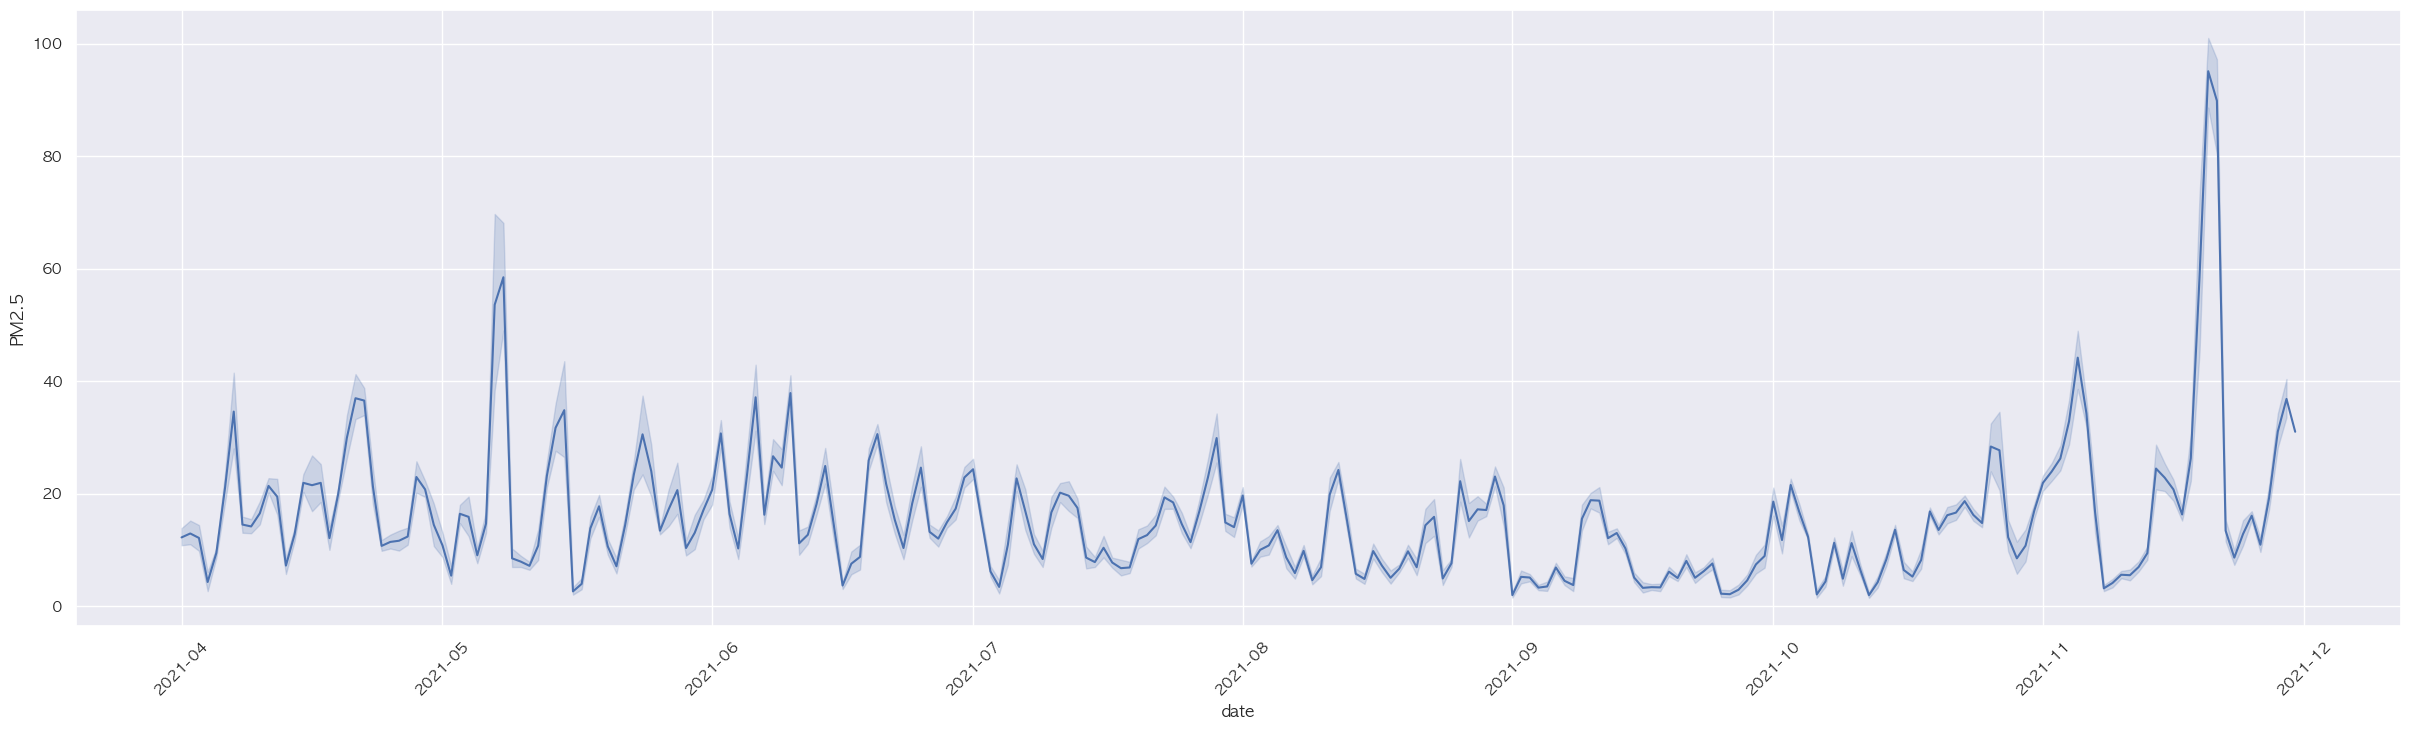

In [74]:
plt.figure(figsize=(30,8))
sns.lineplot(x='date', y=var, data=df)
plt.xticks(rotation=45)
plt.show()

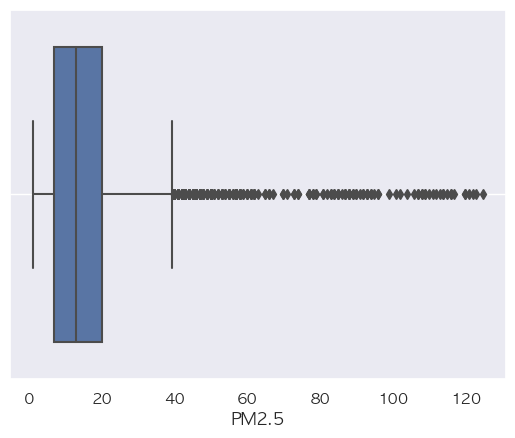

In [75]:
sns.boxplot(x = df[var])
plt.grid()
plt.show()

위 정보로 부터 파악한 내용 정리


#### 10) Count (Target)

In [76]:
var = 'count'

변수가 내포하고 있는 의미
- 따릉이의 대여량 -> 우리가 예측해야 할 변수!

In [77]:
df[var].value_counts()
# 숫자 데이터의 분포가 넓기 떄문에 수치형 변수이다

count
20     45
16     45
24     44
21     44
25     44
       ..
553     1
789     1
803     1
794     1
519     1
Name: count, Length: 757, dtype: int64

변수가 수치형인지 범주형인지


변수의 결측치 존재 여부 및 조치 방안

In [78]:
df[[var]].isna().sum()

count    0
dtype: int64

변수의 기초 통계량 확인

In [79]:
df[[var]].describe().T

,count,mean,std,min,25%,50%,75%,max
count,5827.00,215.12,185.97,1.00,53.00,186.00,315.00,1746.00


변수의 분포 확인

In [113]:
len(df[df['count'] >= 1000])

6

In [114]:
df[df['count'] >= 1000]

,date,hour,PM10,PM2.5,ozone,temperature,precipitation,windspeed,humidity,visibility,count,month,day,weekday
664,2021-04-28,17,53.00,15.00,0.04,17.10,0,3.00,42,2000,1126,4,28,2
665,2021-04-28,18,49.00,15.00,0.03,17.20,0,3.00,40,2000,1600,4,28,2
3709,2021-09-02,17,15.00,7.00,0.05,25.80,0,1.50,63,2000,1090,9,2,3
3710,2021-09-02,18,20.00,8.00,0.04,25.40,0,2.10,65,2000,1746,9,2,3
3711,2021-09-02,19,17.00,9.00,0.04,24.90,0,1.10,66,2000,1086,9,2,3
3734,2021-09-03,18,6.00,6.00,0.04,28.00,0,2.30,44,2000,1026,9,3,4


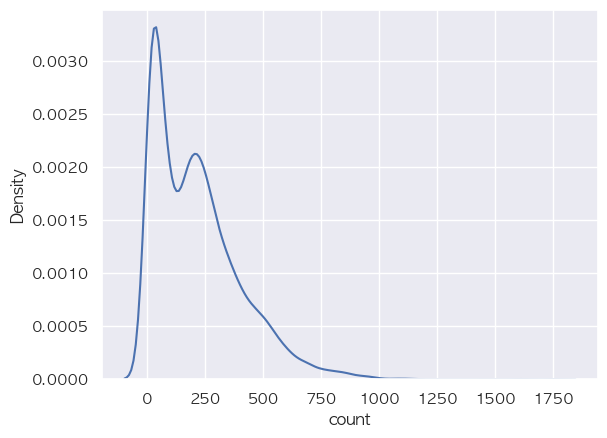

In [80]:
sns.kdeplot(df[var])
plt.show()

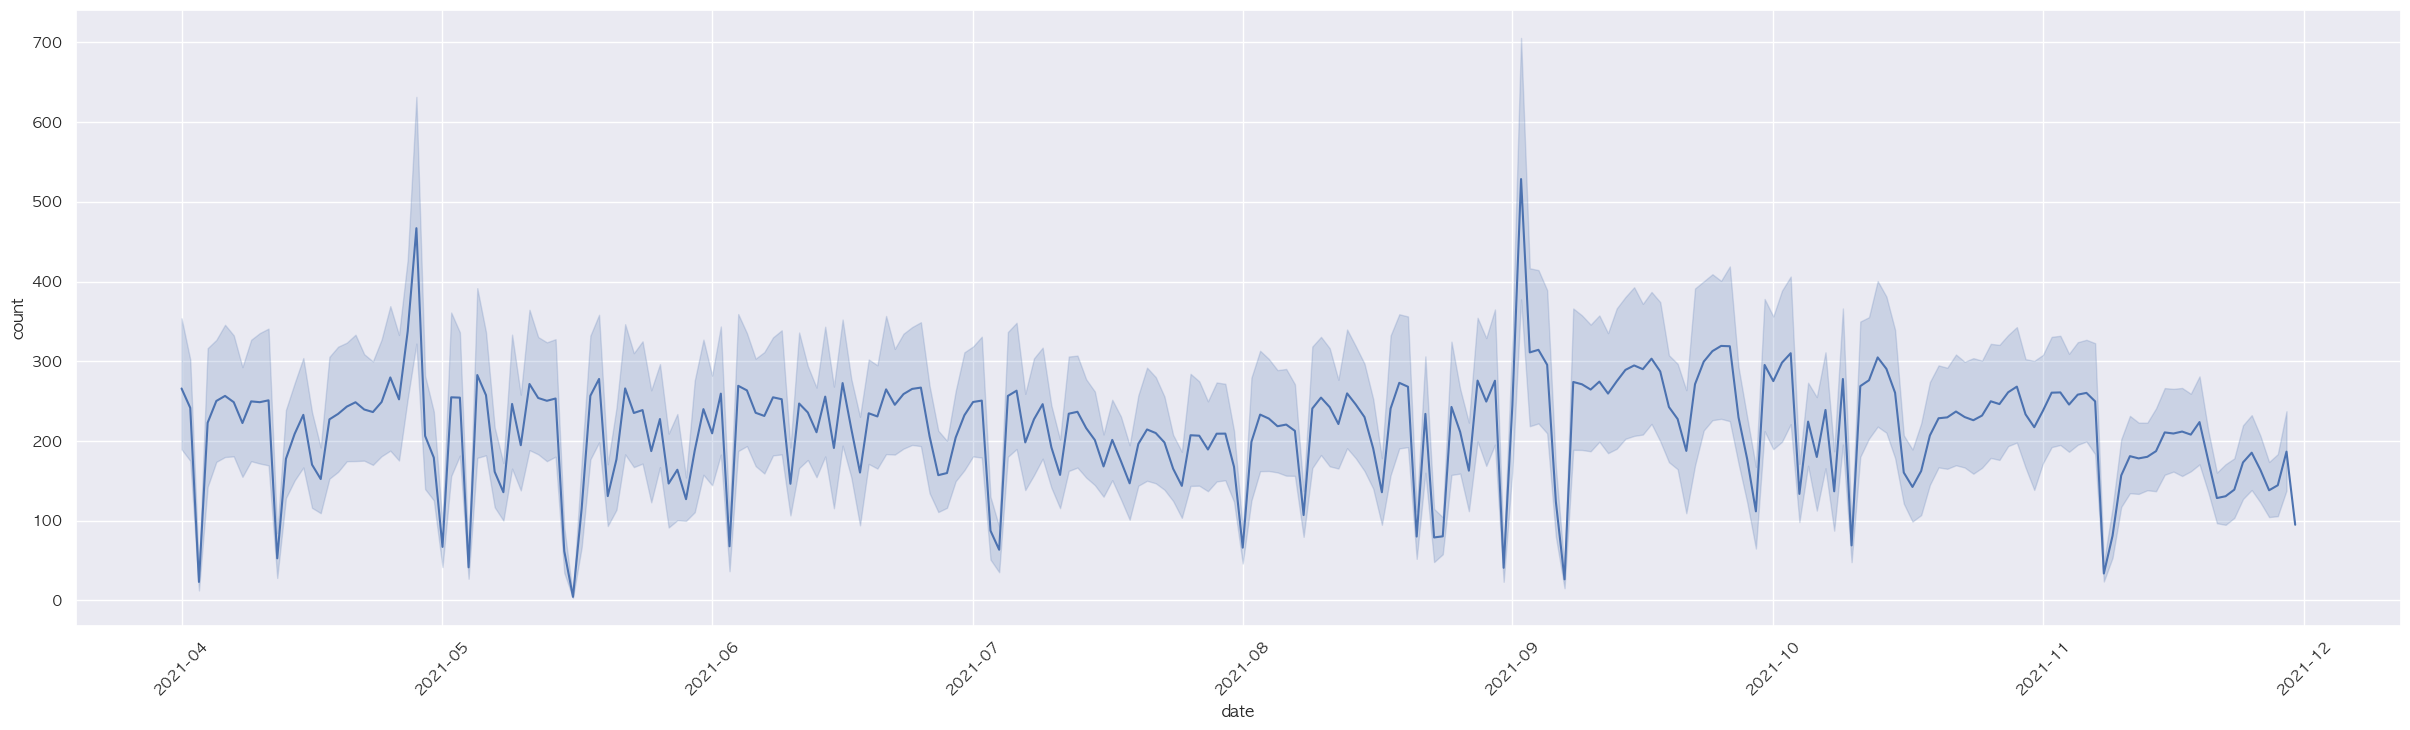

In [81]:
plt.figure(figsize=(30,8))
sns.lineplot(x='date', y=var, data=df)
plt.xticks(rotation=45)
plt.show()

In [82]:
df.head(3)

,date,hour,PM10,PM2.5,ozone,temperature,precipitation,windspeed,humidity,visibility,count,month,day,weekday
0,2021-04-01,1,42.00,21.00,0.00,13.10,0,1.40,49,2000,46,4,1,3
1,2021-04-01,2,41.00,21.00,0.00,12.40,0,2.10,53,2000,40,4,1,3
2,2021-04-01,3,30.00,13.00,0.02,13.10,0,3.40,43,2000,31,4,1,3


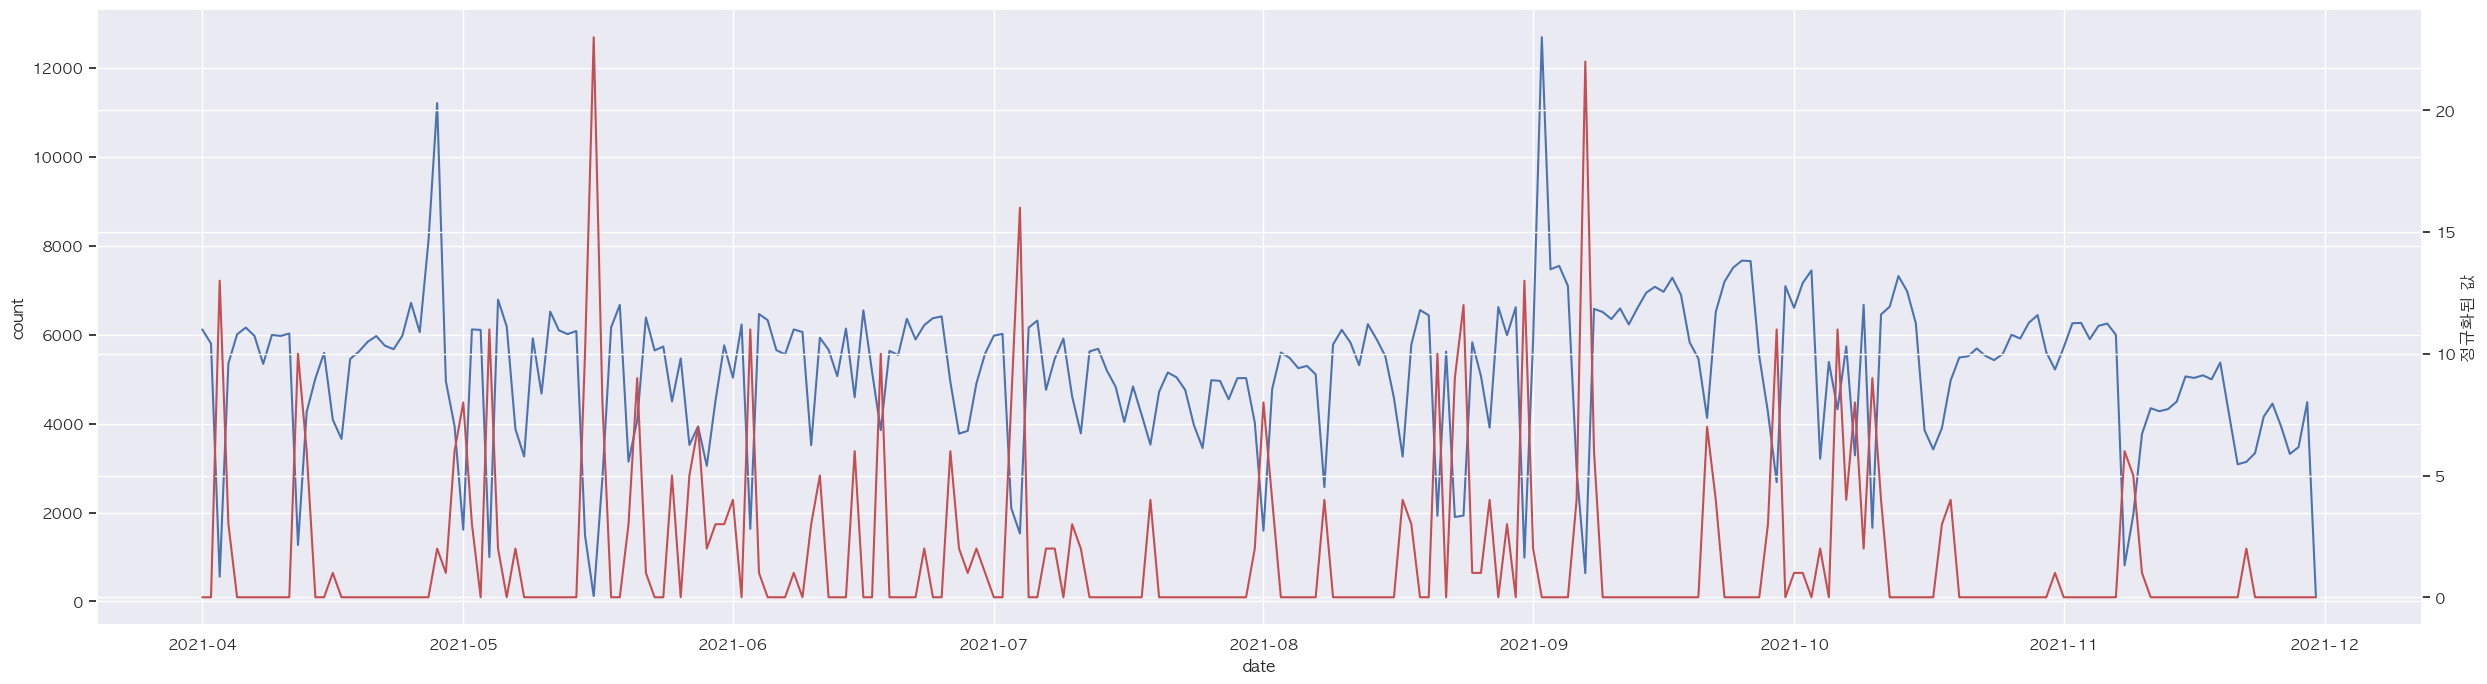

In [112]:
tmp = df.groupby('date', as_index=False)[['precipitation','count']].sum()

plt.figure(figsize=(30,8))
sns.lineplot(x='date', y='count', data=tmp)

ax2 = plt.gca().twinx()
sns.lineplot(x='date', y='precipitation', data=tmp, color='r')
ax2.set_ylabel('정규화된 값')

plt.xticks(rotation=45)
plt.show()

In [92]:
tmp[tmp['count'] < 1000]

,date,count
2,2021-04-03,559
33,2021-05-04,999
45,2021-05-16,110
152,2021-08-31,984
159,2021-09-07,636
221,2021-11-08,813
243,2021-11-30,95


In [87]:
tmp[tmp['count'] > 10000]

,date,count
27,2021-04-28,11208
154,2021-09-02,12687


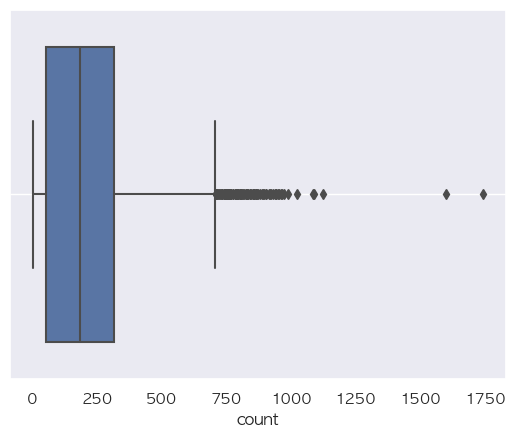

In [85]:
sns.boxplot(x = df[var])
plt.grid()
plt.show()

위 정보로 부터 파악한 내용 정리


* 데이터는 21년 4월 1일 01시부터 21년 11월 29일 00시까지 수집한 시계열 데이터이다.
    * 다만, 일부 요일에서 1~2개의 수집하지 못한 관측치가 존재한다.

* Target 변수인 count에 이상치가 존재한다
    * 10000 이상의 데이터와 1000 이하의 데이터

In [93]:
df.head(3)

,date,hour,PM10,PM2.5,ozone,temperature,precipitation,windspeed,humidity,visibility,count,month,day,weekday
0,2021-04-01,1,42.00,21.00,0.00,13.10,0,1.40,49,2000,46,4,1,3
1,2021-04-01,2,41.00,21.00,0.00,12.40,0,2.10,53,2000,40,4,1,3
2,2021-04-01,3,30.00,13.00,0.02,13.10,0,3.40,43,2000,31,4,1,3


In [ ]:
# 같은 요일과 시간을 기준으로 그룹화하여 각 그룹의 개수를 계산
duplicates = df.groupby(['month','day','weekday'])['count'].count()

# 개수가 1보다 큰 그룹 찾기
duplicates = duplicates[duplicates < 24]

# 결과 출력
print(duplicates)

In [94]:
df.to_csv('./sbikedata_fix.csv',index=False)